# Assignment 1: Scalable Processing
## Yelp Reviews and Authenticity

Big Data Management | by Christian Bank Lauridsen | chbl@itu.dk | date

## Connecting to the Spark Cluster job using the two JobParameters.json

To connect this jupyter notebook with your Spark cluster, we need to tell jupyter how it can access the spark cluster. Below code accomplishes that. Do not worry about how it works, just run the cell once to connect. 

In [1]:
#####################################################################
# DO NOT CHANGE ANYTHING HERE.
# IF YOU HAVE PROBLEMS, CHECK THE ASSIGNMENT GUIDE CAREFULLY 
#####################################################################
from IPython.display import Javascript, display
import jupyterlab
import os, json, pyspark
from pyspark.sql import SparkSession, functions as F
from pyspark.conf import SparkConf
from py4j.protocol import Py4JJavaError
import matplotlib.pyplot as plt


def show_popup(message):
    display(Javascript(f'alert("{message}")'))

def check_correct_file_location():
    items = os.listdir('/work')
    items_expected = ['yelp', 'Home','JobParameters.json', 'emails']
    if sorted(items) != sorted(items_expected):
        items_to_be_moved = [item for item in items if item not in items_expected and item[0] != '.'] # Ignore hidden files starting with .
        show_popup(f"Warning: Found these files {items_to_be_moved} that should (most likely) be moved inside your Home folder. Make sure your Git repository and notebooks are all saved inside your Home folder and not at the 'root'/top of filesystem. Please move your files to prevent them from disappearing.")
    if 'emails' not in items_expected:
        show_popup(f'Error: the folder "emails" does not seem to be accessible - did you remeber to add it to the Spark Cluster job and JupyterLab job?')
    
check_correct_file_location()

SUPPORTED_SPARK_VERSION = "3.3.1"
SUPPORTED_JUPYTERLAB_VERSION = "3.5.1"
if jupyterlab.__version__ != SUPPORTED_JUPYTERLAB_VERSION:
    show_popup(f"Wrong JupyterLab version :( When starting the UCloud job you selected {jupyterlab.__version__} but it should have been {SUPPORTED_JUPYTERLAB_VERSION}")
    show_popup("Please shutdown this JupyterLab job and follow the instructions carefully in the UCloud setup guide PDF on LearnIT") 
elif '_EXECUTED_' in globals(): # Only execute this cell once.
    # check if variable '_EXECUTED_' exists in the global variable namespace
    print("Already been executed once, not running again!")
else:
    print("Cell has not been executed before. Please restart the UCloud jobs if any error message pops up. Running setup cell now.")
    # Two files are automatically read: JobParameters.json for the Spark Cluster job using a temporary spark instance
    # and JobParameters.json for the Jupyter Lab job to extract the hostname of the cluster. 

    MASTER_HOST_NAME = None

    # Open the parameters Jupyter Lab app was launched with
    with open('/work/JobParameters.json', 'r') as file:
        JUPYTER_LAB_JOB_PARAMS = json.load(file)
        # from pprint import pprint; pprint(JUPYTER_LAB_JOB_PARAMS) 
        for resource in JUPYTER_LAB_JOB_PARAMS['request']['resources']:
            if 'hostname' in resource.keys():
                MASTER_HOST_NAME = resource['hostname']
    
    if MASTER_HOST_NAME != "spark-cluster":
        msg = f"The JupyterLab job was started using spark hostname {MASTER_HOST_NAME}. This is not recommended, please start it using spark-cluster instead"
        show_popup(msg)
        print(msg)
    else:
        MASTER_HOST = f"spark://{MASTER_HOST_NAME}:7077"

        conf = SparkConf().setAll([
                ("spark.app.name", 'reading_job_params_app'), 
                ("spark.master", MASTER_HOST),
            ])

        spark = SparkSession.builder.config(conf=conf)\
                                    .getOrCreate()
        
        if spark.version != SUPPORTED_SPARK_VERSION:
            show_popup(f"Wrong Spark Cluster version :( When starting the UCloud job you selected {spark.version} but it should have been {SUPPORTED_SPARK_VERSION}")
            show_popup("Please shutdown this JupyterLab job, the Spark Cluster and follow the instructions carefully in the UCloud setup guide PDF on LearnIT") 

        CLUSTER_PARAMETERS_JSON_DF = spark.read.option("multiline","true").json('/work/JobParameters.json')
        
        # Extract cluster info from the specific JobParameters.json
        NODES = CLUSTER_PARAMETERS_JSON_DF.select("request.replicas").first()[0]
        CPUS_PER_NODE = CLUSTER_PARAMETERS_JSON_DF.select("machineType.cpu").first()[0] - 1
        MEM_PER_NODE = CLUSTER_PARAMETERS_JSON_DF.select("machineType.memoryInGigs").first()[0]

        CLUSTER_CORES_MAX = CPUS_PER_NODE * NODES
        CLUSTER_MEMORY_MAX = MEM_PER_NODE * NODES 
        
        if CPUS_PER_NODE > 1:
            EXECUTOR_CORES = CPUS_PER_NODE - 1  # set cores per executor on worker node
        else:
            EXECUTOR_CORES = CPUS_PER_NODE 

        try:
            EXECUTOR_MEMORY = int(
                MEM_PER_NODE / (CPUS_PER_NODE / EXECUTOR_CORES) * 0.5
            )  # set executor memory in GB on each worker node
        except ZeroDivisionError:
            show_popup(f"Please make sure you selected 3 nodes for the Spark Cluster, each with 24 GB of ram. You selected {MEM_PER_NODE} GB ram and {NODES} node(s)")
            
        # Make sure there is a dir for spark logs
        if not os.path.exists('spark_logs'):
            os.mkdir('spark_logs')

        conf = SparkConf().setAll(
            [
                ("spark.app.name", 'spark_assignment'), # Change to your liking 
                ("spark.sql.caseSensitive", False), # Optional: Make queries strings sensitive to captialization
                ("spark.master", MASTER_HOST),
                ("spark.cores.max", CLUSTER_CORES_MAX),
                ("spark.executor.cores", EXECUTOR_CORES),
                ("spark.executor.memory", str(EXECUTOR_MEMORY) + "g"),
                ("spark.eventLog.enabled", True),
                ("spark.eventLog.dir", "spark_logs"),
                ("spark.history.fs.logDirectory", "spark_logs"),
                ("spark.deploy.mode", "cluster"),
            ]
        )

        ## check executor memory, taking into accout 10% of memory overhead (minimum 384 MiB)
        CHECK = (CLUSTER_CORES_MAX / EXECUTOR_CORES) * (
            EXECUTOR_MEMORY + max(EXECUTOR_MEMORY * 0.10, 0.403)
        )

        assert (
            int(CHECK) <= CLUSTER_MEMORY_MAX
        ), "Executor memory larger than cluster total memory!"

        # Stop previous session that was just for loading cluster params
        spark.stop()

        # Start new session with above config, that has better resource handling
        spark = SparkSession.builder.config(conf=conf)\
                                    .getOrCreate()
        sc = spark.sparkContext
        _EXECUTED_ = True
        print("Success!")

<IPython.core.display.Javascript object>

Cell has not been executed before. Please restart the UCloud jobs if any error message pops up. Running setup cell now.
Success!


Click on the "SparkMonitor" tab at the top in Jupyter Lab to see the status of running code on the cluster.

In [5]:
from IPython.display import Javascript, display
import jupyterlab
import os, json, pyspark
from pyspark.sql import SparkSession, functions as F
from pyspark.conf import SparkConf
from py4j.protocol import Py4JJavaError
import matplotlib.pyplot as plt

spark = SparkSession.builder.getOrCreate()

business = spark.read.json("datasets/yelp/yelp_academic_dataset_business.json")
users = spark.read.json("datasets/yelp/yelp_academic_dataset_user.json")
reviews = spark.read.json("datasets/yelp/yelp_academic_dataset_review.json")

26/01/05 10:53:54 WARN Utils: Your hostname, Christians-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.26.8.19 instead (on interface en0)
26/01/05 10:53:54 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


26/01/05 10:53:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


26/01/05 10:54:04 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


## Loading the data
Here we specify where the yelp datasets are located on UCloud and read then using the spark session.

In [2]:
# Read in the business and review files
# This is the path to the shared datasets provided by adding an the dataset input folder
# when submitting the spark cluster job.
business = spark.read.json('file:////work/yelp/yelp_academic_dataset_business.json') # Use the file:/// prefix to indicate we want to read from the cluster's filesystem
business = business.persist()
# Persist 2 commonly used dataframes since they're used for later computations
# https://sparkbyexamples.com/spark/spark-difference-between-cache-and-persist/

users = spark.read.json("file:////work/yelp/yelp_academic_dataset_user.json")

reviews = spark.read.json('file:////work/yelp/yelp_academic_dataset_review.json')
reviews = reviews.persist()

NameError: name 'spark' is not defined

## PySpark example usage

In [3]:
# Show PySpark dataframes:
reviews.show()

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|XQfwVwDr-v0ZS3_Cb...|   0|2018-07-07 22:09:11|    0|KU_O5udG6zpxOg-Vc...|  3.0|If you decide to ...|     0|mh_-eMZ6K5RLWhZyI...|
|7ATYjTIgM3jUlt4UM...|   1|2012-01-03 15:28:18|    0|BiTunyQ73aT9WBnpR...|  5.0|I've taken a lot ...|     1|OyoGAe7OKpv6SyGZT...|
|YjUWPpI6HXG530lwP...|   0|2014-02-05 20:30:30|    0|saUsX_uimxRlCVr67...|  3.0|Family diner. Had...|     0|8g_iMtfSiwikVnbP2...|
|kxX2SOes4o-D3ZQBk...|   1|2015-01-04 00:01:03|    0|AqPFMleE6RsU23_au...|  5.0|Wow!  Yummy, diff...|     1|_7bHUi9Uuf5__HHc_...|
|e4Vwtrqf-wpJfwesg...|   1|2017-01-14 20:54:15|    0|Sx8TMOWLNuJBWer-0...|  4.0|Cute inter

In [4]:
business.show()

+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|          city|               hours|is_open|     latitude|     longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|1616 Chapala St, ...|{null, null, null...|Pns2l4eNsfO8kk83d...|Doctors, Traditio...| Santa Barbara|                null|      0|   34.4266787|  -119.7111968|Abby Rappoport, L...|      93101|           7|  5.0|   CA|
|87 Grasso Plaza S...|{null, null, null...|mpf3x-BjTdTEA3yCZ...|Shipping Centers,...|        Affton|{8:0-18:30, 0:0-0...|      1|   

In [5]:
# Get number of rows with no sampling:
reviews.count()

6990280

In [ ]:
# OPTIONAL:
# Reduce resource usage and make queries run faster
# by only using a small sample of the dataframe
# and overwriting previous variable "df".
# Useful while developing, not so much to
# provide final answers. Therefore: Remember to 
# to re-read the df when done developing code using
# df = spark.read etc like above.
reviews = reviews.sample(withReplacement=False, fraction=1/50)

# Get number of rows after sampling:
reviews.count() 

In [6]:
business.show()

+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|          city|               hours|is_open|     latitude|     longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|1616 Chapala St, ...|{null, null, null...|Pns2l4eNsfO8kk83d...|Doctors, Traditio...| Santa Barbara|                null|      0|   34.4266787|  -119.7111968|Abby Rappoport, L...|      93101|           7|  5.0|   CA|
|87 Grasso Plaza S...|{null, null, null...|mpf3x-BjTdTEA3yCZ...|Shipping Centers,...|        Affton|{8:0-18:30, 0:0-0...|      1|   

Example: Say we're only interested in reviews of good mexican restaurants in Arizona. You can delete this when you do your own thing. 

In [7]:
# Filter to only Arizona businesses with "Mexican" as part of their categories
az_mex = business.filter(business.state == "AZ")\
                .filter(business.categories.rlike("Mexican"))\
                .select("business_id", "name")

# Join with the reviews
az_mex_rs = reviews.join(az_mex, on="business_id", how="inner")

# Filter to only 5 star reviews
good_az_mex_rs = az_mex_rs.filter(az_mex_rs.stars == 5)\
                        .select("name","text")

# Print the top 20 rows of the DataFrame
good_az_mex_rs.show()

# Convert to pandas (local object) and save to local file system
good_az_mex_rs.toPandas().to_csv("good_az_reviews.csv", header=True, index=False, encoding='utf-8')


+--------------------+--------------------+
|                name|                text|
+--------------------+--------------------+
|Casa Molina Del N...|We've been coming...|
|St Mary's Mexican...|Some of the fines...|
|Street- Taco and ...|Top notch street ...|
|Indian Frybread-M...|This place is a h...|
|St Mary's Mexican...|One of my favorit...|
|Street- Taco and ...|This is my favori...|
|Street- Taco and ...|Great food!  Grea...|
|            BK Tacos|Quality ingredien...|
|Street- Taco and ...|Best tacos in Tuc...|
|        El Merendero|This place was fr...|
|        El Merendero|To the reviewer w...|
|Taqueria Pico De ...|If you are lookin...|
|               Penca|Good unique Mexic...|
|   La Mesa Tortillas|Incredible red ch...|
|               Penca|I love this place...|
|            BK Tacos|This place is the...|
|Indian Frybread-M...|Wow! My sister ha...|
|St Mary's Mexican...|Carne Seca burro ...|
|             Club 21|The food was exce...|
|      El Charro Cafe|This is th

See assignment PDF for task descriptions.

In [22]:
users.show()

+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+-----+--------------------+----+--------------------+-----+---------+------------+------+--------------------+-------------------+
|average_stars|compliment_cool|compliment_cute|compliment_funny|compliment_hot|compliment_list|compliment_more|compliment_note|compliment_photos|compliment_plain|compliment_profile|compliment_writer| cool|               elite|fans|             friends|funny|     name|review_count|useful|             user_id|      yelping_since|
+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+-----+--------------------+----+--------------------+-----+---------+------------+------+--------------------+-------------------+
|         

### Task 3.1.1:

In [6]:
# Find the total number of reviews for all businesses.

reviews.count()

6990280

### Task 3.1.2:

+------------------+-----+------------+
|              name|stars|review_count|
+------------------+-----+------------+
|   Blues City Deli|  5.0|         991|
|Free Tours By Foot|  5.0|         769|
|  Carlillos Cocina|  5.0|         799|
+------------------+-----+------------+



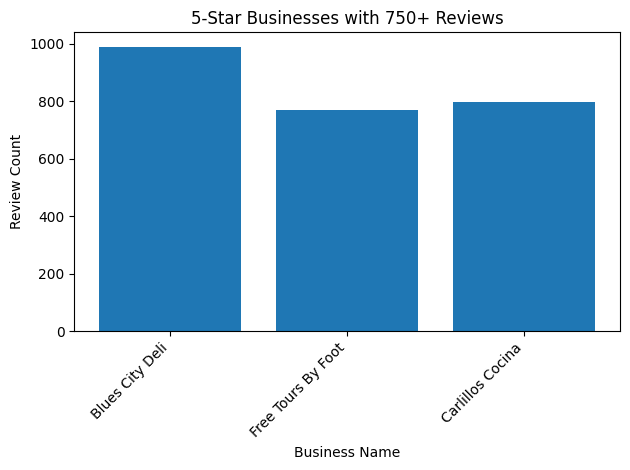

In [7]:
# Find all businesses that have received 5 stars (on average: Use business.stars column)
# and that have been reviewed by 750 or more users. The output should be in the form of a
# DataFrame of (name, stars, review count).

five_stars_business = business.filter((business.stars==5) & (business.review_count >= 750))\
                              .select("name", "stars", "review_count")

five_stars_business.show()

# Plot barplot using matplotlib 
five_stars_business_plots = five_stars_business.toPandas()

plt.bar(five_stars_business_plots['name'], five_stars_business_plots['review_count'])
plt.xlabel('Business Name')
plt.ylabel('Review Count')
plt.title('5-Star Businesses with 750+ Reviews')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Task 3.1.3: 

In [8]:
# Find influencers who have written more than 750 reviews. And have an average rating
# higher than 4 stars. The output should be in the form of a Spark Table/DataFrame of user
# id.

# users.show()

influencers = users.filter((users.average_stars > 4) & (users.review_count > 750))\
                    .select("user_id")

print("total count " + str(influencers.count()))

influencers.show(truncate=False)



total count 1028
+----------------------+
|user_id               |
+----------------------+
|MGPQVLsODMm9ZtYQW-g_OA|
|RgDVC3ZUBqpEe6Y1kPhIpw|
|VHdY6oG2JPVNjihWhOooAQ|
|UQFE3BT1rsIYrcDvu_XVow|
|0G-QF457q_0Z_jKqh6xWiA|
|ITa3vh5ERI90G_WP4SmGUQ|
|oW2bCSJ5bIHyRnoZvkHwDg|
|13f_vtUZEmlzweL91bmVng|
|UVUIi0q38pAvsfuEEppe0Q|
|zDBOdWtl2PsNY38IeoE5cQ|
|7Na1pUcEv3oF_QTRwZ-2iw|
|MUzkXfPS9JaMgJ907orz0g|
|YWFbTcVnun8i03XnEU7kVg|
|Ve0LUwcrzxL7w0RYgY4Aaw|
|i5Cm53q0pmklQsX8soi3tw|
|IzJ36jX6V6ky5BtoN-Agng|
|eTvp_hYnsrI5-ow_sQ31_g|
|7PHHxsjyk7I7oM6ENxwZZQ|
|WWnhqRnWWjutMqh-2SzEuQ|
|0QdwQLVxZpgy9Qb2Qakflw|
+----------------------+
only showing top 20 rows



### Task 3.1.4: 

In [9]:
# Find the businesses names and their average ratings for ones that have been reviewed by
# more than 5 influencer users. You can use a view created from your answer to Q3.

# Join reviews with influencers → only influencer reviews
review_influencers = reviews.join(influencers, on="user_id", how="inner") \
    .withColumnRenamed("stars", "review_stars") # make disambiguous because both business and review have coloumns stars

# Join influencer reviews with businesses
business_review_influencers = business.join(review_influencers, on="business_id", how="inner")
# business_review_influencers.show()

# For each business count distinct influencers
influencer_counts = business_review_influencers.groupBy("business_id", "name")\
                                                .agg(F.countDistinct("user_id").alias("influencer_count"))
# influencer_counts.show()

# Keep only businesses with > 5 influencer reviewers

good_businesses = influencer_counts.filter(influencer_counts.influencer_count > 5)
# good_businesses.show()

# Compute average rating per business (from influencer reviews only)
avg_rating = business_review_influencers.groupBy("business_id", "name")\
                                            .agg(F.avg("review_stars").alias("avg_rating"))

# Result (combine avg_stars with good_businesses)
result = good_businesses.join(avg_rating, on=["business_id", "name"], how="inner")

print("total count " + str(result.count()))
result.select("name", "avg_rating").show(n=20, truncate=False)




total count 2298


+---------------------------------------+------------------+
|name                                   |avg_rating        |
+---------------------------------------+------------------+
|Henry's Coffee Bistro                  |3.875             |
|Modesto Tapas Bar & Restaurant         |4.571428571428571 |
|swah-rey                               |4.833333333333333 |
|Hattie B’s Hot Chicken - Lower Broadway|4.333333333333333 |
|Whole Foods Market                     |4.0588235294117645|
|Santa Barbara Certified Farmers Market |5.0               |
|Pacific Counter                        |4.857142857142857 |
|Cyrano's                               |3.888888888888889 |
|Ted Peter's Famous Smoked Fish         |4.0               |
|HandleBar                              |4.333333333333333 |
|Brio Italian Grille                    |3.9285714285714284|
|Mike's Ice Cream                       |4.153846153846154 |
|Tria Cafe Wash West                    |4.666666666666667 |
|Helena Avenue Bakery   

### Task 3.1.5: 

In [12]:
# Find an ordered list of users based on the average star counts they have given in all their reviews.
from pyspark.sql.functions import col
avg_star_users = users.select("average_stars").orderBy(col("average_stars").desc())

print("total count " + str(avg_star_users.count()))
avg_star_users.show()

total count 1987897
+-------------+
|average_stars|
+-------------+
|          5.0|
|          5.0|
|          5.0|
|          5.0|
|          5.0|
|          5.0|
|          5.0|
|          5.0|
|          5.0|
|          5.0|
|          5.0|
|          5.0|
|          5.0|
|          5.0|
|          5.0|
|          5.0|
|          5.0|
|          5.0|
|          5.0|
|          5.0|
+-------------+
only showing top 20 rows



### Task 3.2.1: Data Exploration

In [10]:
# What is the percentage of reviews that contain a variant of the word "authentic", and do not contain "inauthentic". 

from pyspark.sql.functions import col

# What is the percentage of reviews that contain a variant of the word "authentic", and do not contain "inauthentic"
review_with_authentic = reviews.filter(col("text").rlike("(?i)authentic") & (~col("text").rlike("(?i)inauthentic")))

# Get number of rows for before and after
total_reviews = reviews.count()
authentic_reviews = review_with_authentic.count()

# Percentage
percentage = (authentic_reviews / total_reviews) * 100
print(f"Percentage of reviews that contain a variant of the word \"authentic\": {percentage:.2f}%")


Percentage of reviews that contain a variant of the word "authentic": 1.78%


In [11]:
from pyspark.sql.functions import col

# Look up synonyms for variants of authentic
AUTHENTIC_WORDS = ["authentic", "original", "real", "legitimate", "legit", "credible", "genuine", "valid"]
BAD_WORDS = ["inauthentic", "illegitimate", "ungenuine", "unreal", "invalid, unoriginal"]

# Create regex patterns for searching, case insensitive
authentic_pattern = "(?i)(" + "|".join(AUTHENTIC_WORDS) + ")"  # (?i) = case insensitive, "|".join() creates an OR pattern, example (authentic|original|real).
bad_pattern = "(?i)(" + "|".join(BAD_WORDS) + ")"  

# Get the reviews that contain any authentic words but not bad words
reviews_with_authentic = reviews.filter(col("text").rlike(authentic_pattern) & (~col("text").rlike(bad_pattern))) # rlike (like with regex)

# Get number of rows for before and after
total_reviews = reviews.count()
authentic_reviews = reviews_with_authentic.count()

# Percentage
percentage = (authentic_reviews / total_reviews) * 100
print(f"Percentage of reviews that contain a variant of the word \"authentic\": {percentage:.2f}%")

Percentage of reviews that contain a variant of the word "authentic": 24.03%


In [13]:
# Is there a difference in the amount of authenticity language used in the different areas? (e.g., by state, north/south, urban/rural)

# Cube implementation 

AUTHENTIC_WORDS = ["authentic", "original", "real", "legitimate", "legit", "credible", "genuine", "valid"]
authentic_pattern = "(?i)(" + "|".join(AUTHENTIC_WORDS) + ")" 

# Flag reviews with authenticity language
reviews_flagged = reviews.join(business.select("business_id", "state", "city"), "business_id") \
    .withColumn("has_authenticity", F.col("text").rlike(authentic_pattern).cast("int"))

# Full cube over state, city
cube_results = reviews_flagged.cube("state", "city") \
    .agg(
        F.sum("has_authenticity").alias("authenticity_count"),
        F.count("*").alias("total_count")
    ) \
    .withColumn("percentage", (F.col("authenticity_count") / F.col("total_count") * 100)) \
    .orderBy(F.desc("percentage"))

print("total count before " + str(cube_results.count()))
cube_results.show(20, truncate=False)

# However this gives a lot of null values, so we can filter them out if needed
cube_filtered = cube_results.filter(F.col("state").isNotNull() & F.col("city").isNotNull())
print("total count after " + str(cube_filtered.count()))
cube_filtered.show(20, truncate=False)

total count before 2911


+-----+-------------------+------------------+-----------+------------------+
|state|city               |authenticity_count|total_count|percentage        |
+-----+-------------------+------------------+-----------+------------------+
|null |East Greenville    |4                 |5          |80.0              |
|PA   |East Greenville    |4                 |5          |80.0              |
|null |New Britian        |4                 |6          |66.66666666666666 |
|NV   |Sparks,            |4                 |6          |66.66666666666666 |
|PA   |New Britian        |4                 |6          |66.66666666666666 |
|null |Sparks,            |4                 |6          |66.66666666666666 |
|null |Bradenton Beach    |5                 |8          |62.5              |
|FL   |Bradenton Beach    |5                 |8          |62.5              |
|null |Pittsgrove Township|3                 |5          |60.0              |
|PA   |MIDDLE CITY WEST   |3                 |5          |60.0  

total count after 1467


+-----+-------------------+------------------+-----------+------------------+
|state|city               |authenticity_count|total_count|percentage        |
+-----+-------------------+------------------+-----------+------------------+
|PA   |East Greenville    |4                 |5          |80.0              |
|NV   |Sparks,            |4                 |6          |66.66666666666666 |
|PA   |New Britian        |4                 |6          |66.66666666666666 |
|FL   |Bradenton Beach    |5                 |8          |62.5              |
|NJ   |Vineland           |3                 |5          |60.0              |
|NJ   |Pittsgrove Township|3                 |5          |60.0              |
|NV   |RENO AP            |3                 |5          |60.0              |
|PA   |MIDDLE CITY WEST   |3                 |5          |60.0              |
|FL   |HUdson             |10                |17         |58.82352941176471 |
|LA   |St Rose            |7                 |12         |58.333

+-----+------------------+-----------+------------------+
|state|authenticity_count|total_count|percentage        |
+-----+------------------+-----------+------------------+
|PA   |416555            |1598960    |26.051621053684894|
|FL   |256187            |1161545    |22.05571028242556 |
|LA   |182551            |761673     |23.967109245043478|
|TN   |148283            |614388     |24.135074252752332|
|MO   |124145            |502385     |24.71112791982245 |
|IN   |117325            |489752     |23.95600222153253 |
|NV   |101386            |430678     |23.541021366310794|
|AZ   |100490            |431708     |23.27730780990855 |
|CA   |86320             |348856     |24.743733804205746|
|NJ   |58993             |260897     |22.611605346171093|
|ID   |35458             |157572     |22.502728911227884|
|AB   |33361             |109436     |30.48448408202054 |
|DE   |15613             |70302      |22.208472020710648|
|IL   |10499             |51832      |20.255826516437722|
+-----+-------

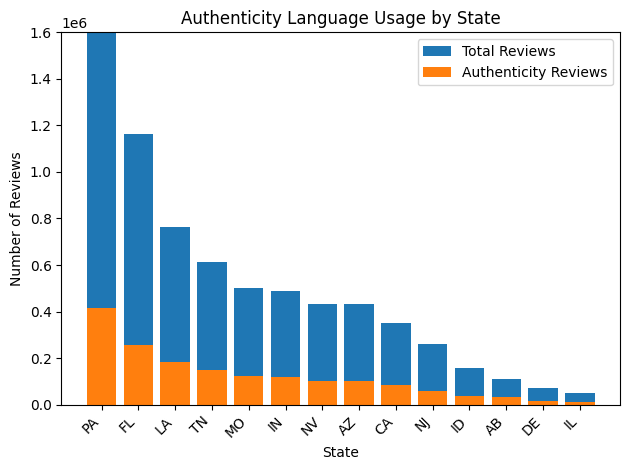

In [23]:
# Simple state ranking based on authenticity counts
state_ranking = reviews_flagged.filter(F.col("state").isNotNull())\
    .groupBy("state")\
    .agg(
        F.sum("has_authenticity").alias("authenticity_count"),
        F.count("*").alias("total_count")
    )\
    .withColumn("percentage", (F.col("authenticity_count") / F.col("total_count") * 100))\
    .filter(F.col("total_count") >= 50000)\
    .orderBy(F.desc("authenticity_count"))\

state_ranking.show(20, truncate=False)

# plot barplot using matplotlib where has authenticity_count is on top of total counts
state_ranking_pd = state_ranking.toPandas()
plt.bar(state_ranking_pd['state'], state_ranking_pd['total_count'], label='Total Reviews')
plt.bar(state_ranking_pd['state'], state_ranking_pd['authenticity_count'], label='Authenticity Reviews')
plt.xlabel('State')
plt.ylabel('Number of Reviews')
plt.ylim(0, 1_600_000) 
plt.title('Authenticity Language Usage by State')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


In [15]:
from pyspark.sql import functions as F
# How many reviews contain the string "genuine" grouped by businesses type ?
review_with_genuine = reviews.filter(col("text").rlike("(?i)genuine"))

reduced_business = business.select("business_id", "categories")

# Join with business to get business type and find all business types with explode and split
business_review_with_genuine = review_with_genuine.join(reduced_business, on="business_id", how="inner")\
                              .withColumn("business_type", F.explode(F.split(F.col("categories"), ", ")))
#business_review_with_genuine.show()

business_review_with_genuine.drop_duplicates(["business_type"]).select("business_type")

# Groupby business type and count
business_review_with_genuine.groupBy("business_type").count().show()

total_review_with_genuine = business_review_with_genuine.count()

print(f"Total reviews with genuine: {total_review_with_genuine}")

+--------------------+-----+
|       business_type|count|
+--------------------+-----+
|    Historical Tours|  121|
|      Paddleboarding|   15|
|      Dermatologists|   82|
|     Pet Photography|   10|
|            Day Spas|  616|
|         Hobby Shops|  100|
|               Reiki|   73|
|          Bubble Tea|  142|
|Child Care & Day ...|  107|
|             Tanning|  141|
|     Bed & Breakfast|   97|
|              Boxing|   31|
|            Handyman|   30|
|               Salad| 1391|
|       Beauty & Spas| 2978|
|            Beer Bar|  473|
|           Education|  360|
|             Arcades|   56|
|         Art Classes|   28|
|          Bookstores|   85|
+--------------------+-----+
only showing top 20 rows



Total reviews with genuine: 181107


In [21]:
# How many reviews contain the string "legitimate" grouped by type of cuisine? 
# What about "illegitimate"?

# Note: The data unfortunately doesn’t have a "cuisine type" column you can group by. So you need to be creative to answer this question

# Get businesses that are resturants
resturants = business.filter(business.categories.rlike("(?i)restaurant"))
resturants_exploded = resturants.withColumn("cuisine_type", F.explode(F.split(F.col("categories"), ", ")))\
                              .select("business_id", "name", "cuisine_type")

# resturants_exploded.show()


ASIAN_CUSINE_LIST = ["Chinese", "Japanese", "Korean", "Thai", "Vietnamese", "Indian", "Filipino", "Asian"]
asian_pattern = "(?i)(" + "|".join(ASIAN_CUSINE_LIST) + ")"
asian_cuisines = resturants_exploded.filter(col("cuisine_type").rlike(asian_pattern))
#asian_cuisines.show()

EUROPEAN_CUISINE_LIST = ["Italian", "French", "Spanish", "Greek", "German", "British", "Portuguese"]
european_pattern = "(?i)(" + "|".join(EUROPEAN_CUISINE_LIST) + ")"
european_cuisines = resturants_exploded.filter(col("cuisine_type").rlike(european_pattern))
#european_cuisines.show()

AMERICAN_CUISINE_LIST = ["American", "Mexican", "Brazilian", "Argentinian", "Colombian"]
american_pattern = "(?i)(" + "|".join(AMERICAN_CUISINE_LIST) + ")"
american_cuisines = resturants_exploded.filter(col("cuisine_type").rlike(american_pattern))
#american_cuisines.show()


all_cuisines = asian_cuisines.union(european_cuisines).union(american_cuisines)

# all_cusines.show(all_cusines.count(), truncate=False)

# Reviews with legitimate
reviews_with_legitimate = reviews.filter(col("text").rlike("(?i)legitimate"))
reduced_reviews_with_legitimate = reviews_with_legitimate.select("business_id", "text")

# Reviews with illegitimate
reviews_with_illegitimate = reviews.filter(col("text").rlike("(?i)illegitimate"))
reduced_reviews_with_illegitimate = reviews_with_illegitimate.select("business_id", "text")

# Join with cusines with reviews
business_review_with_legitimate = reduced_reviews_with_legitimate.join(all_cuisines, on="business_id", how="inner").select("business_id", "cuisine_type")
business_review_with_illegitimate = reduced_reviews_with_illegitimate.join(all_cuisines, on="business_id", how="inner").select("business_id", "cuisine_type")

# Group by cuisine type and aggrete count
business_review_with_legitimate = business_review_with_legitimate.groupBy("cuisine_type")\
                                 .agg(F.count("*").alias("count"))\
                                 .orderBy(F.desc("count"))
print("total count legitimate " + str(business_review_with_legitimate.count()))
business_review_with_legitimate.show(n=25, truncate=False)


business_review_with_illegitimate = business_review_with_illegitimate.groupBy("cuisine_type")\
                                    .agg(F.count("*").alias("count"))\
                                    .orderBy(F.desc("count"))
print("total count ilegitimate " + str(business_review_with_illegitimate.count()))

business_review_with_illegitimate.show(truncate=False)


total count legitimate 23
+----------------------+-----+
|cuisine_type          |count|
+----------------------+-----+
|American (New)        |560  |
|American (Traditional)|544  |
|Mexican               |295  |
|Italian               |271  |
|Chinese               |159  |
|Japanese              |151  |
|Asian Fusion          |123  |
|Thai                  |86   |
|Vietnamese            |65   |
|Latin American        |61   |
|French                |60   |
|Korean                |50   |
|Greek                 |42   |
|Indian                |35   |
|Spanish               |19   |
|British               |13   |
|German                |12   |
|New Mexican Cuisine   |11   |
|Brazilian             |9    |
|Filipino              |7    |
|Pan Asian             |4    |
|Colombian             |4    |
|Japanese Curry        |1    |
+----------------------+-----+

total count ilegitimate 8
+----------------------+-----+
|cuisine_type          |count|
+----------------------+-----+
|American (Tradit

In [22]:
#Is there a difference in the amount of authenticity language used in the different areas?
# (e.g., by state, north/south, urban/rural)

# Note: As part of answering this question, you could compute the full cube or rollup com-
# bining the location of the business and whether the review contains authenticity lan-
# guage, and use this to aggregate their counts per state and city

# Group businesses by state.
business_by_state_city = business.select("business_id", "state", "city")

reduced_reviews_with_authentic = reviews_with_authentic.select("business_id", "text")
#reduced_reviews_with_authentic.show()

# Join with reviews that contain authenticity language
business_by_state_city_with_authentic = business_by_state_city.join(reduced_reviews_with_authentic, on="business_id", how="inner")
#business_by_state_city_with_authentic.show()

# Group by state and city and aggregate counts
authentic_by_state_city = business_by_state_city_with_authentic.groupBy("state", "city")\
                        .agg(F.count("*").alias("count"))\
                        .orderBy("count", ascending=False)
print("total count " + str(authentic_by_state_city.count()))
authentic_by_state_city.show()


total count 1402
+-----+----------------+------+
|state|            city| count|
+-----+----------------+------+
|   PA|    Philadelphia|269428|
|   LA|     New Orleans|153891|
|   TN|       Nashville|112129|
|   FL|           Tampa|106831|
|   AZ|          Tucson| 94574|
|   IN|    Indianapolis| 88547|
|   NV|            Reno| 83835|
|   CA|   Santa Barbara| 66916|
|   MO|     Saint Louis| 65745|
|   AB|        Edmonton| 31041|
|   ID|           Boise| 23960|
|   FL|      Clearwater| 18239|
|   FL|Saint Petersburg| 18185|
|   NV|          Sparks| 15914|
|   MO|       St. Louis| 15328|
|   LA|        Metairie| 14339|
|   TN|        Franklin| 12731|
|   FL|  St. Petersburg| 12560|
|   CA|          Goleta| 11298|
|   DE|      Wilmington| 10041|
+-----+----------------+------+
only showing top 20 rows



### Task 3.2.2: Hypothesis Testing

In [10]:
# Can you identify a difference in the relationship between authenticity language and 
# typically negative words, in restaurants serving South American or Asian cuisine compared
# to restaurants serving European cuisine? And to what degree? Can you think of any other
# categories you can compare in the context of the study?.
from pyspark.mllib.linalg import Matrices
from pyspark.mllib.stat import Statistics

# Filter to only restaurants and explode cuisine types
resturants_exploded = resturants.withColumn("cuisine_type", F.explode(F.split(F.col("categories"), ", "))).select("business_id", "name", "cuisine_type")

# Cuisines (South American, Asian, European)
south_american_cuisine = ["Brazilian", "Argentinian", "Peruvian", "Colombian", "Chilean", "Cuban", "Venezuelan", "Guatemalan", "Costa Rican"]
asian_cuisine = ["Chinese", "Japanese", "Korean", "Thai", "Vietnamese", "Indian", "Filipino", "Asian"]
european_cuisine = ["Italian", "French", "Spanish", "Greek", "German", "British", "Portuguese"]

south_american_pattern = "(?i)(" + "|".join(south_american_cuisine) + ")"
asian_pattern = "(?i)(" + "|".join(asian_cuisine) + ")"
european_pattern = "(?i)(" + "|".join(european_cuisine) + ")"

# Join reciews to get only those with relevant cuisine types
reviews_with_cuisine = reviews.join(resturants_exploded.select("business_id", "cuisine_type"), on="business_id", how="inner") \
    .withColumn("cuisine_group",
                F.when(F.col("cuisine_type").rlike(south_american_pattern), "South American")
                 .when(F.col("cuisine_type").rlike(asian_pattern), "Asian")
                 .when(F.col("cuisine_type").rlike(european_pattern), "European")
                 .otherwise("Other")) \
                 .filter(F.col("cuisine_group") != "Other")  # Only keep relevant cuisine groups

reviews_with_cuisine_reduces = reviews_with_cuisine.select("business_id", "text", "cuisine_group")

# Authenticity and negative word flags
reviews_contain_authenticity_negativity = reviews_with_cuisine_reduces \
    .withColumn("has_authenticity", F.col("text").rlike(authentic_pattern)) \
    .withColumn("has_negative", F.col("text").rlike(bad_pattern))

# Count autehnticity and negative words by cuisine group and total number of reviews
authenticity_negativity_counts = reviews_contain_authenticity_negativity.groupBy("cuisine_group") \
    .agg(F.sum(F.col("has_authenticity").cast("int")).alias("authenticity_count"),
         F.sum(F.col("has_negative").cast("int")).alias("negative_count"),
         F.count("*").alias("total_count")) \
    .orderBy("cuisine_group")

authenticity_negativity_counts.cache()
authenticity_negativity_counts.show()

# Authenticity by cuisine
counts = authenticity_negativity_counts.collect()

values = []
for row in counts:
    # Column-major order for Matrices.dense: [authenticity1, authenticity2, authenticity3, no_auth1, no_auth2, no_auth3]
    values.append(row['authenticity_count'])
values_no_auth = [row['total_count'] - row['authenticity_count'] for row in counts]

# Combine for column-major
matrix_values = values + values_no_auth

# Create contingency matrix: 3 cuisines x 2 columns (authenticity / no authenticity)
contingency_matrix = Matrices.dense(3, 2, matrix_values)

# Perform chi-square test
chi_result = Statistics.chiSqTest(contingency_matrix)
print("Authenticity by cuisine:\n")
print(chi_result)
print("-----------------------------------")

# Negativity by cuisine
neg_values = [row['negative_count'] for row in counts]
neg_no_values = [row['total_count'] - row['negative_count'] for row in counts]

matrix_values_neg = neg_values + neg_no_values
neg_matrix = Matrices.dense(3, 2, matrix_values_neg)

chi_result_neg = Statistics.chiSqTest(neg_matrix)
print("Negativity by cuisine:\n")
print(chi_result_neg)
print("-----------------------------------")

# Add proportion columns
authenticity_negativity_percent = authenticity_negativity_counts \
    .withColumn("authenticity_pct", F.round(F.col("authenticity_count") / F.col("total_count") * 100, 2)) \
    .withColumn("negative_pct", F.round(F.col("negative_count") / F.col("total_count") * 100, 4)) \
    .orderBy("cuisine_group")

authenticity_negativity_percent.show()

+--------------+------------------+--------------+-----------+
| cuisine_group|authenticity_count|negative_count|total_count|
+--------------+------------------+--------------+-----------+
|         Asian|            270157|          1100|     993635|
|      European|            178603|           931|     683667|
|South American|             19534|            91|      68490|
+--------------+------------------+--------------+-----------+

Authenticity by cuisine:

Chi squared test summary:
method: pearson
degrees of freedom = 2 
statistic = 338.36376979086003 
pValue = 0.0 
Very strong presumption against null hypothesis: the occurrence of the outcomes is statistically independent..
-----------------------------------
Negativity by cuisine:

Chi squared test summary:
method: pearson
degrees of freedom = 2 
statistic = 22.398524831685048 
pValue = 1.3684285656623274E-5 
Very strong presumption against null hypothesis: the occurrence of the outcomes is statistically independent..
--------

### Task 3.3: Building a Rating Prediction Model

In [16]:
from pyspark.sql.functions import when
from pyspark.sql.types import DoubleType
from functools import reduce
# MLlib
from pyspark.ml.feature import StopWordsRemover, Tokenizer, Word2Vec, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

# Multiclass classification

# Three classes: High (4-5 stars), Medium (2-3 stars), Low (1 star)

# Step 1 - Load data of reviews from resturants only
resturants = business.filter(business.categories.rlike("(?i)restaurant"))
# Rename column "stars" from business to avoid problem with "stars" in reviews
resturants = resturants.select("business_id")

reviews_resturants = reviews.join(resturants, on="business_id", how="inner")\
    .select("review_id", "text", "stars")

In [18]:
# Step 2 - Create new column "rating_type" with the three classes based on the stars column
# 2 = High (4-5 stars), 
# 1 = Medium (2-3 stars), 
# 0 = Low (1 star)
reviews_resturants = reviews_resturants.withColumn(
    "rating_type", 
    when(reviews_resturants.stars >= 4, 2)\
    .when((reviews_resturants.stars >= 2) & (reviews_resturants.stars <= 3), 1) \
    .otherwise(0)
)
reviews_resturants = reviews_resturants.withColumn("rating_type", F.col("rating_type").cast(DoubleType())) # Cast to double for MLlib
print("total count " + str(reviews_resturants.count()))
reviews_resturants.show(truncate=True)

total count 4724684
+--------------------+--------------------+-----+-----------+
|           review_id|                text|stars|rating_type|
+--------------------+--------------------+-----+-----------+
|KU_O5udG6zpxOg-Vc...|If you decide to ...|  3.0|        1.0|
|saUsX_uimxRlCVr67...|Family diner. Had...|  3.0|        1.0|
|AqPFMleE6RsU23_au...|Wow!  Yummy, diff...|  5.0|        2.0|
|Sx8TMOWLNuJBWer-0...|Cute interior and...|  4.0|        2.0|
|JrIxlS1TzJ-iCu79u...|I am a long term ...|  1.0|        0.0|
|_ZeMknuYdlQcUqng_...|Amazingly amazing...|  5.0|        2.0|
|pUycOfUwM8vqX7KjR...|Had a party of 6 ...|  3.0|        1.0|
|l3Wk_mvAog6XANIuG...|Locals recommende...|  4.0|        2.0|
|XW_LfMv0fV21l9c6x...|Love going here f...|  4.0|        2.0|
|8JFGBuHMoiNDyfcxu...|Good food--loved ...|  4.0|        2.0|
|UBp0zWyH60Hmw6Fsa...|The bun makes the...|  4.0|        2.0|
|OAhBYw8IQ6wlfw1ow...|Great place for b...|  5.0|        2.0|
|oyaMhzBSwfGgemSGu...|Tremendous servic...|  5.0| 

In [23]:
# Step 3 - Clean data and preprocess text:
# Make everything lowercase, remove punctuation and special characters
reviews_resturants = reviews_resturants.withColumn("text", F.lower(F.regexp_replace("text", r"[^a-zA-Z0-9\s]", "")))


In [24]:
# Step 4 - Split data into training and testing datasets
train_data, test_data = reviews_resturants.randomSplit([0.8, 0.2], seed=42)


Original train class distribution: {0.0: 453586, 1.0: 757791, 2.0: 2566563}


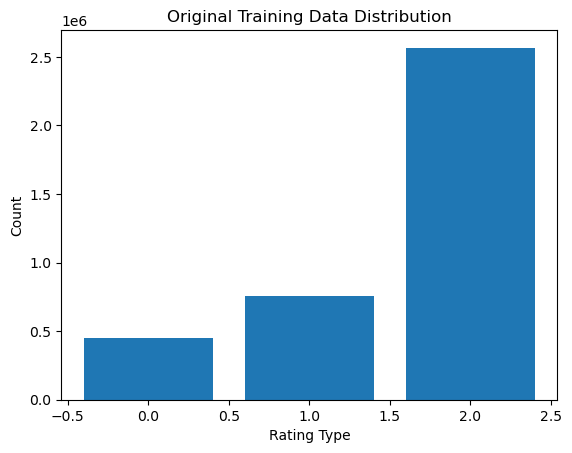

+-----------+-----+
|rating_type|count|
+-----------+-----+
|        0.0|30050|
|        1.0|30171|
|        2.0|30227|
+-----------+-----+



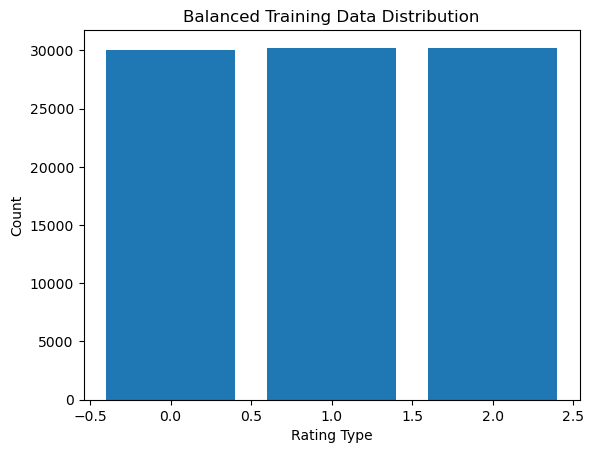

In [28]:
# Step 5 - Balance train data
target_per_class = 30000
seed = 42

# Get class counts
class_counts = dict(train_data.groupBy("rating_type").count().collect())
print("Original train class distribution:", class_counts)

# Plot barplot using matplotlib
train_data_plot = train_data.groupBy("rating_type").count().orderBy("rating_type").toPandas()
plt.bar(train_data_plot['rating_type'], train_data_plot['count'])
plt.xlabel('Rating Type')
plt.ylabel('Count')
plt.title('Original Training Data Distribution')
plt.show()


balanced_parts = []
for label, cnt in class_counts.items():
    df_label = train_data.filter(F.col("rating_type") == label)
    # Downsample
    frac = target_per_class / float(cnt)
    sampled = df_label.sample(withReplacement=False, fraction=frac, seed=seed)
    balanced_parts.append(sampled)
    
train_balanced = reduce(lambda a, b: a.union(b), balanced_parts).cache()
train_balanced.groupBy("rating_type").count().orderBy("rating_type").show()

# Plot barplot using matplotlib
train_balanced_plot = train_balanced.groupBy("rating_type").count().orderBy("rating_type").toPandas()
plt.bar(train_balanced_plot['rating_type'], train_balanced_plot['count'])
plt.xlabel('Rating Type')
plt.ylabel('Count')
plt.title('Balanced Training Data Distribution')
plt.show()


In [29]:
# Step 6 -  Feature extraction
# TF-IDF
tokenizer = Tokenizer(inputCol="text", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
hashingTF = HashingTF(inputCol="filtered_words", outputCol="raw_features", numFeatures=10000)
idf = IDF(inputCol="raw_features", outputCol="features")
lr = LogisticRegression(featuresCol="features", labelCol="rating_type", maxIter=10)

# Use a pipeline to chain the stages together
pipeline_tfidf = Pipeline(stages=[tokenizer, remover, hashingTF, idf, lr])
model_tfidf = pipeline_tfidf.fit(train_balanced)
prediction_tfidf = model_tfidf.transform(test_data)

print("succes")

succes


In [15]:
# Step 6 -  Feature extraction
# Word2Vec
#Filter out rows with empty or null word arrays (prevents Word2Vec crash)
train_balanced = train_balanced.filter(F.length(F.col("text")) > 10)
train_balanced = train_balanced.filter(F.col("text").isNotNull())
train_balanced = train_balanced.repartition(50).cache()
print("Materializing training data...")
_ = train_balanced.count() # Force Spark to cache data

word2Vec = Word2Vec(
    vectorSize=50, 
    minCount=10,
    maxIter=1, 
    inputCol="filtered_words", 
    outputCol="features"
)

lr_w2v = LogisticRegression(
    featuresCol="features", 
    labelCol="rating_type", 
    maxIter=10,
    regParam=0.3,
    elasticNetParam=0.8
)

pipeline_w2v = Pipeline(stages=[tokenizer, remover, word2Vec, lr_w2v])

print(f"Training on {train_balanced.count()} balanced rows...")
model_w2v = pipeline_w2v.fit(train_balanced)

prediction_w2v = model_w2v.transform(test_data)
print("succes")

Materializing training data...
Training on 90432 balanced rows...


Py4JJavaError: An error occurred while calling o1565.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 183.0 failed 4 times, most recent failure: Lost task 0.3 in stage 183.0 (TID 4326) (node1 executor 2): TaskResultLost (result lost from block manager)
Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2228)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2249)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2268)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2293)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1021)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1020)
	at org.apache.spark.mllib.feature.Word2Vec.$anonfun$doFit$6(Word2Vec.scala:453)
	at scala.collection.immutable.Range.foreach$mVc$sp(Range.scala:158)
	at org.apache.spark.mllib.feature.Word2Vec.doFit(Word2Vec.scala:362)
	at org.apache.spark.mllib.feature.Word2Vec.fit(Word2Vec.scala:322)
	at org.apache.spark.ml.feature.Word2Vec.fit(Word2Vec.scala:182)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)


In [30]:
# Step 7 - Evaluate the model
evaluator = MulticlassClassificationEvaluator(
    labelCol="rating_type", 
    predictionCol="prediction", 
    metricName="accuracy"
)

acc_tfidf = evaluator.evaluate(prediction_tfidf)
#acc_w2v = evaluator.evaluate(prediction_w2v)

# Print the accuracy
print(f"TF-IDF Accuracy: {acc_tfidf:.2f}")
#print(f"Word2Vec Accuracy: {acc_w2v:.2f}")


TF-IDF Accuracy: 0.79


In [31]:
from pyspark.sql import Row
# Example new reviews
example_reviews = [
    Row(text="The food was incredible and the staff were very friendly"),
    Row(text="Horrible service, my order was wrong and took too long"),
    Row(text="It was okay, nothing special but not terrible"),
    Row(text="Fantastic pizza and quick delivery!"),
    Row(text="The soup was cold and bland"),
]

example_df = spark.createDataFrame(example_reviews)

predictions_example = model_tfidf.transform(example_df)
predictions_example.select("text", "prediction").show(truncate=False)

#predictions_example2 = model_w2v.transform(example_df)
#predictions_example2.select("text", "prediction").show(truncate=False)

+--------------------------------------------------------+----------+
|text                                                    |prediction|
+--------------------------------------------------------+----------+
|The food was incredible and the staff were very friendly|2.0       |
|Horrible service, my order was wrong and took too long  |0.0       |
|It was okay, nothing special but not terrible           |1.0       |
|Fantastic pizza and quick delivery!                     |2.0       |
|The soup was cold and bland                             |0.0       |
+--------------------------------------------------------+----------+

